In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'alzheimers-dataset-4-class-of-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F457093%2F861496%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T200429Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4558a1974651c93af03bf154e7173bfcdccf250559428b1dd8a8d53bbff2b3455551114a88d5a2c792e28794184ee7489cb58728e6aec81b205657116bd7e2c23066528e4b4205b3bc96a14b80c55a14b0e9f4118aff61460750cc1fb4c0636bb916e91a7e9fd9527627a9a38809d1086edad312e4fa4004a3a02c2ccbed293a8510856c0718bb650579e57de028e9753e0fce5069468c88e5bbf8a54f58d4fdebb49925e928da86fa3758da0119839a3a1e5b210e0db5154af986df240db7e448e38b8317da773a25c6151357fe2d922be2cc611d017abb4197175349c3e60f25767dbee5b85780f0a35d6e93dc842d2436c8e855ca27f9e380bbfb02edb059'

KAGGLE_INPUT_PATH='/dataset/input'
KAGGLE_WORKING_PATH='/dataset/working'
KAGGLE_SYMLINK='dataset'

!umount /dataset/input/ 2> /dev/null
shutil.rmtree('/dataset/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 35779075 bytes downloaded
Downloaded and uncompressed: alzheimers-dataset-4-class-of-images
Data source import complete.


# Import Modules

In [2]:
# import system libs
import os
import time
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [3]:
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create Functions

### Dataframe creation

In [4]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    tr_files, tr_classes = define_paths(data_dir+'/train')
    ts_files, ts_classes = define_paths(data_dir+'/test')
    dummy_df = define_df(tr_files, tr_classes)
    ts_df = define_df(ts_files, ts_classes)

    # valid and test dataframe
    strat = dummy_df['labels']
    tr_df, valid_df = train_test_split(dummy_df,  train_size= 0.75, shuffle= True, random_state= 123, stratify= strat)

    return tr_df, valid_df, ts_df

In [5]:
# # Generate data paths with labels
# def define_paths(data_dir):
#     filepaths = []
#     labels = []

#     folds = os.listdir(data_dir)
#     for fold in folds:
#         foldpath = os.path.join(data_dir, fold)
#         filelist = os.listdir(foldpath)
#         for file in filelist:
#             fpath = os.path.join(foldpath, file)
#             filepaths.append(fpath)
#             labels.append(fold)

#     return filepaths, labels


# # Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
# def define_df(files, classes):
#     Fseries = pd.Series(files, name='filepaths')
#     Lseries = pd.Series(classes, name='labels')
#     return pd.concat([Fseries, Lseries], axis= 1)

# # Split dataframe to train, valid, and test
# def split_data(data_dir):
#     # train dataframe
#     tr_files, tr_classes = define_paths(data_dir+'/train')
#     ts_files, ts_classes = define_paths(data_dir+'/test')
#     tr_df = define_df(tr_files, tr_classes)
#     dummy_df = define_df(ts_files, ts_classes)

#     # valid and test dataframe
#     strat = dummy_df['labels']
#     valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

#     return tr_df, valid_df, test_df

### Image generation from dataframe

In [6]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (300, 300)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    # Initialize an empty list to store batch sizes
    valid_batch_sizes = []

    # Iterate through possible factors of ts_length
    for n in range(1, ts_length + 1):
        if ts_length % n == 0 and ts_length / n <= 80:
            valid_batch_sizes.append(ts_length // n)

    # Sort the valid batch sizes in descending order
    valid_batch_sizes.sort(reverse=True)

    # Choose the largest valid batch size
    test_batch_size = valid_batch_sizes[0]
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        img = tf.image.rot90(img, k=np.random.randint(0, 4))
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=0.1)
        img = img + noise
        return img



    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

### Function to call images

In [7]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

### Callbacks

In [8]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1 # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want the model to ask you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
#         ans = 'n'
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^9s}{8:^9s}{9:^10s}{10:^9s}{11:^8s}{12:^9s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'Recall', 'Precision', 'F1', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
        )
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch
        recall = logs.get('recall_m') # get training recall
        v_recall = logs.get('val_recall_m') # get validation recall
        precision = logs.get('precision_m') # get training precision
        v_precision = logs.get('val_precision_m') # get validation precision
        f1 = logs.get('f1_m') # get training f1
        v_f1 = logs.get('val_f1_m') # get validation f1

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{epoch + 1:^3}/{self.epochs:<4} {loss:^9.3f}{acc * 100:^9.3f}{recall * 100:^9.3f}{precision * 100:^9.3f}{f1 * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^9.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^9s}{8:^9s}{9:^10s}{10:^9s}{11:^8s}{12:^9s}'.format(
                                'Epoch', 'Loss', 'Accuracy', 'Recall', 'Precision', 'F1', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
                            )
                            print(msg)

                        except Exception:
                            print('Invalid')

### Function to plot training history

In [9]:
def plot_training(hist):

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    tr_recall = hist.history['recall_m']
    tr_precision = hist.history['precision_m']
    tr_f1 = hist.history['f1_m']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    val_recall = hist.history['val_recall_m']
    val_precision = hist.history['val_precision_m']
    val_f1 = hist.history['val_f1_m']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_recall = np.argmax(val_recall)
    recall_highest = val_recall[index_recall]
    index_precision = np.argmax(val_precision)
    precision_highest = val_precision[index_precision]
    index_f1 = np.argmax(val_f1)
    f1_highest = val_f1[index_f1]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch= {index_loss + 1} (Loss: {val_lowest:.4f})'
    acc_label = f'Best Epoch= {index_acc + 1} (Accuracy: {acc_highest:.4f})'
    recall_label = f'Best Epoch= {index_recall + 1} (Recall: {recall_highest:.4f})'
    precision_label = f'Best Epoch= {index_precision + 1} (Precision: {precision_highest:.4f})'
    f1_label = f'Best Epoch= {index_f1 + 1} (F1: {f1_highest:.4f})'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('seaborn-v0_8')

    plt.subplot(3, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(Epochs, tr_recall, 'r', label= 'Training Recall')
    plt.plot(Epochs, val_recall, 'g', label= 'Validation Recall')
    plt.scatter(index_acc + 1 , recall_highest, s= 150, c= 'blue', label= recall_label)
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(Epochs, tr_precision, 'r', label= 'Training Precision')
    plt.plot(Epochs, val_precision, 'g', label= 'Validation Precision')
    plt.scatter(index_precision + 1 , precision_highest, s= 150, c= 'blue', label= precision_label)
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(Epochs, tr_f1, 'r', label= 'Training F1')
    plt.plot(Epochs, val_f1, 'g', label= 'Validation F1')
    plt.scatter(index_f1 + 1 , f1_highest, s= 150, c= 'blue', label= f1_label)
    plt.title('Training and Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()

    plt.tight_layout
    plt.show()

### Function to create confusion matrix

In [10]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    '''
    This function plot confusion matrix method from sklearn package.
    '''

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

### Metric functions

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Modeling

### Read Data

In [12]:
data_dir = '/dataset/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 10
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 3840 validated image filenames belonging to 4 classes.
Found 1281 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


### Display some sample images

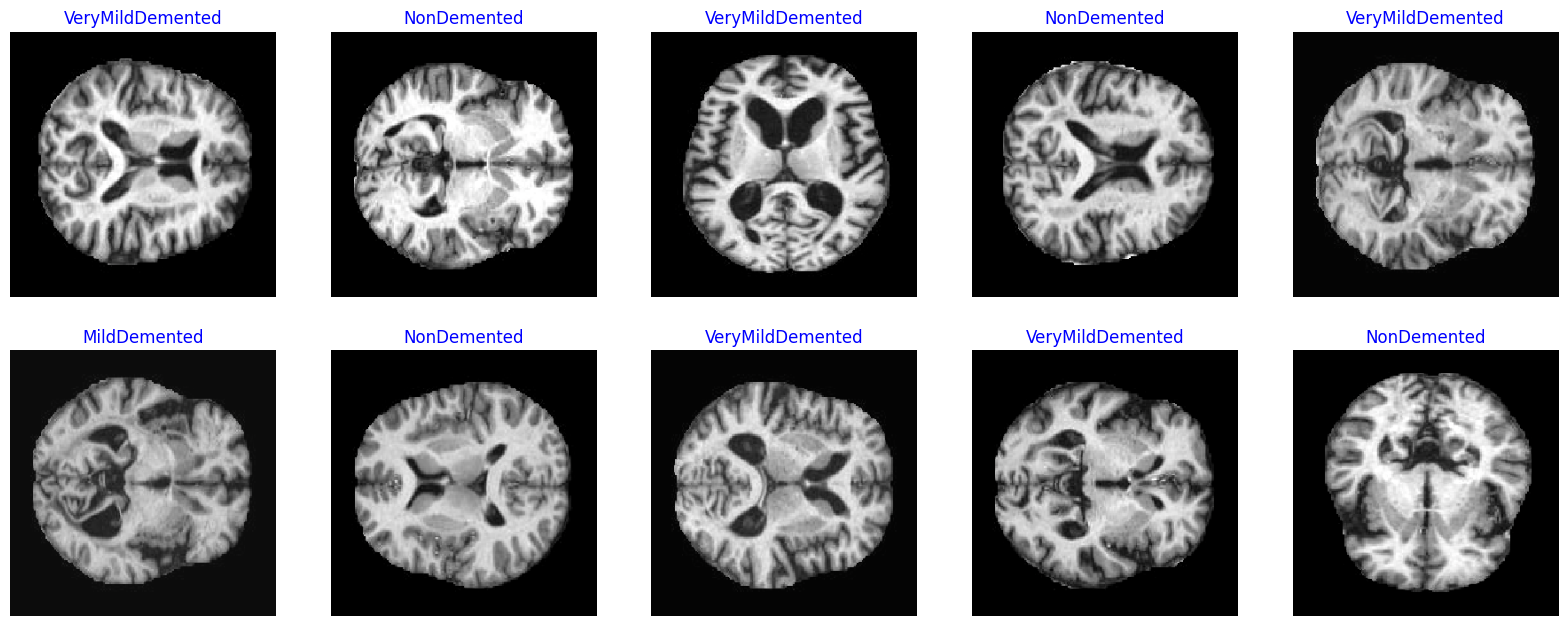

In [13]:
show_images(train_gen)

### Create Model

In [14]:
# Create Model Structure
img_size = (300, 300)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
# tf.random.set_seed(123)
# np.random.seed(123)

# Create the pre-trained ConvNeXtTiny base model
base_model = tf.keras.applications.convnext.ConvNeXtBase(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max',
)

# Build the model on top of the base model
model = Sequential([
    base_model,

    Dense(class_count, activation='softmax')
])

model.compile(Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy', recall_m, precision_m, f1_m])

model.summary()

350926856/350926856 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 87570564 (334.06 MB)
Trainable params: 87570564 (334.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
class_count

NameError: name 'class_count' is not defined

### Set callback parameters

In [15]:
# batch_size = 40   # set batch size for training
epochs = 5   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 5   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 10   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

### Train the model to dataset

In [16]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want the model to ask you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  Recall  Precision   F1     V_loss    V_acc     LR     Next LR   Monitor % ImprovDuration 
 1 /5      1.007   52.266   39.297   60.928   45.926   1.00920  46.526   0.00010  0.00010  accuracy     0.00    516.75  
 2 /5      0.831   59.974   48.724   68.068   55.731   0.76195  65.183   0.00010  0.00010  accuracy    14.75    392.27  
 3 /5      0.737   66.302   58.021   72.290   63.626   0.65915  71.585   0.00010  0.00010  accuracy    10.55    392.50  
 4 /5      0.599   74.115   69.193   77.420   72.817   0.57184  73.068   0.00010  0.00010  accuracy    11.78    393.47  
 5 /5      0.420   83.438   81.198   84.766   82.853   0.41330  85.012   0.00010  0.00010  accuracy    12.58    392.68  
training elapsed time was 0.0 hours, 35.0 minutes, 14.25 seconds)


### Display the model's performance

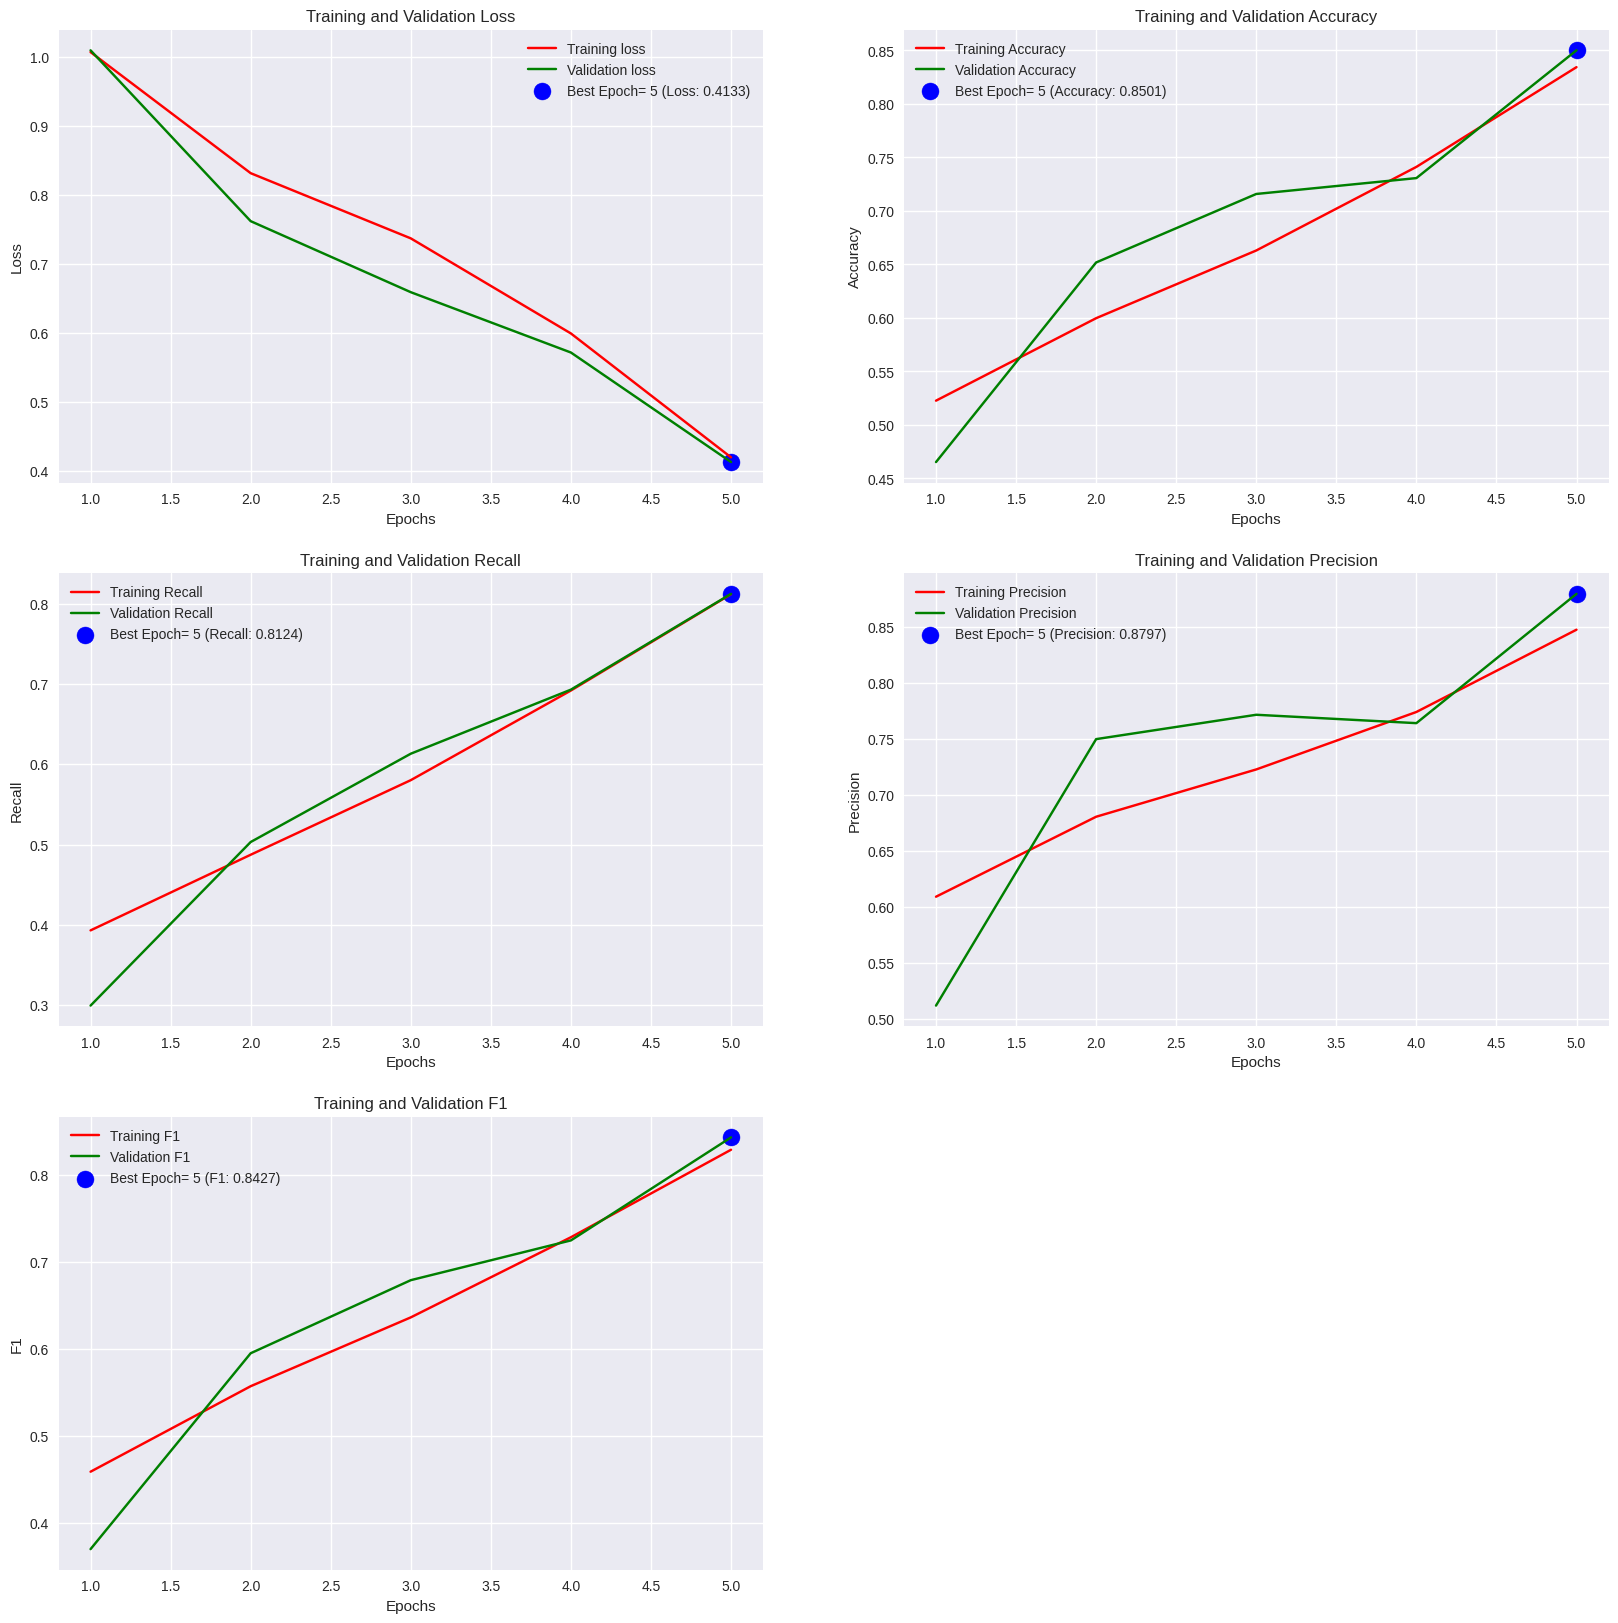

In [17]:
plot_training(history)

### Get predictions

In [18]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[2 2 2 ... 0 3 0]


### Confusion Matrix and Classification Report

Confusion Matrix, Without Normalization
[[ 83   0  24  72]
 [  4   0   1   7]
 [ 21   0 512 107]
 [ 26   0 146 276]]
                  precision    recall  f1-score   support

    MildDemented       0.62      0.46      0.53       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.75      0.80      0.77       640
VeryMildDemented       0.60      0.62      0.61       448

        accuracy                           0.68      1279
       macro avg       0.49      0.47      0.48      1279
    weighted avg       0.67      0.68      0.67      1279



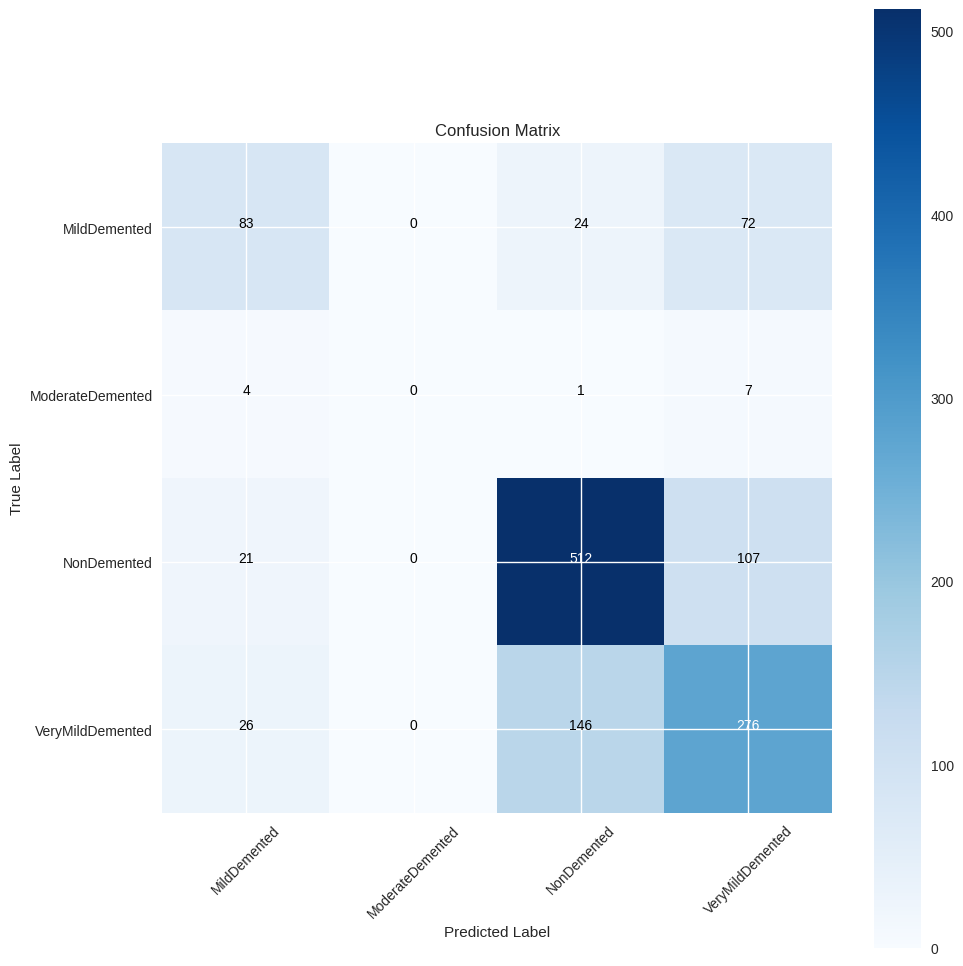

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [21]:
# model.save("my_model.h5")

# Load mô hình đã lưu


ModuleNotFoundError: No module named 'custom_layers'

In [25]:
from keras import layers
class LayerScale(layers.Layer):
    """Layer scale module.

    References:
      - https://arxiv.org/abs/2103.17239

    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.

    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

class StochasticDepth(layers.Layer):
  """Stochastic Depth module.

  It performs batch-wise dropping rather than sample-wise. In libraries like
  `timm`, it's similar to `DropPath` layers that drops residual paths
  sample-wise.

  References:
    - https://github.com/rwightman/pytorch-image-models

  Args:
    drop_path_rate (float): Probability of dropping paths. Should be within
      [0, 1].

  Returns:
    Tensor either with the residual path dropped or kept.
  """

  def __init__(self, drop_path_rate, **kwargs):
      super().__init__(**kwargs)
      self.drop_path_rate = drop_path_rate

  def call(self, x, training=None):
      if training:
          keep_prob = 1 - self.drop_path_rate
          shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
          random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
          random_tensor = tf.floor(random_tensor)
          return (x / keep_prob) * random_tensor
      return x

  def get_config(self):
      config = super().get_config()
      config.update({"drop_path_rate": self.drop_path_rate})
      return config

In [27]:
from tensorflow.keras.models import load_model

# loaded_model = load_model("my_model.h5")
best_model = load_model("my_model.h5", compile=False, custom_objects={ "LayerScale": LayerScale, "StochasticDepth": StochasticDepth } )

# model.load("my_model.h5")

In [59]:
import cv2  # Để đọc và xử lý hình ảnh
import numpy as np

# Định nghĩa một hàm để phân loại ảnh
def classify_image(image_path, model):
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(image_path)
    image = cv2.resize(image, (300, 300))
    # Resize ảnh thành kích thước mong muốn (nếu cần)
    # image = cv2.resize(image, (desired_width, desired_height))
    # Chuẩn hóa dữ liệu ảnh (nếu cần)
    # image = image / 255.0  # Ví dụ

    # Chuẩn bị ảnh cho đầu vào của mô hình
    image = tf.image.rot90(image, k=np.random.randint(0, 4))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.1)
    # image = image + noise

    input_image = np.expand_dims(image, axis=0)  # Thêm chiều batch
    # Thực hiện phân loại
    predictions = model.predict(input_image)

    # Giả sử predictions là một mảng các xác suất cho các lớp
    # Lấy chỉ số của lớp có xác suất cao nhất
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Tại đây, bạn có thể có một từ điển ánh xạ chỉ số lớp sang tên lớp
    # Ví dụ: class_names = {0: 'Cat', 1: 'Dog', 2: 'Bird'}
    # predicted_class = class_names[predicted_class_index]
    name_class = ['MildDermented','ModerateDemented','NonDemented','VeryMildDemented']

    return name_class[predicted_class_index]  # Trả về chỉ số lớp dự đoán

# Sử dụng hàm để phân loại ảnh
image_path = "VMD27.jpg"  # Đường dẫn đến ảnh cần phân loại
predicted_class_index = classify_image(image_path, best_model)
print("Predicted class index:", predicted_class_index)

1/1 [==============================] - 0s 153ms/step
Predicted class index: MildDermented


In [1]:
!python --version

Python 3.10.12


In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
